<a href="https://colab.research.google.com/github/nrshaidat/epitope/blob/master/Random_Forestipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation

**Data prep for only sequence random forest **


---



In [48]:
!pip install biopython
import re
import pandas as pd
from Bio import SeqIO
import os
import numpy as np
!pip install propy3
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio import SeqIO
from propy import PyPro
from propy.GetProteinFromUniprot import GetProteinSequence
from propy import CTD
from propy import AAComposition as AAC
from propy import AAIndex
from itertools import product
from itertools import combinations
def getEpitope(seq):
  patterns= ['[A-Z]+']
  for p in patterns:
    match = re.findall(p, seq)
    return match[0]
def encode_proteins(seq, label):
  DesObject = PyPro.GetProDes(seq)
  ctd = DesObject.GetCTD()
  aad = DesObject.GetAAComp()
  aad.update(ctd)
  aad['label'] = label
  return aad
block = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
all_comb = list(product(block, repeat=2))

def dict_pairs(pairs):
  index_pairs = {}
  for i, pair in enumerate(pairs):
    index_pairs[pair] = i
  return index_pairs
pair_d = dict_pairs(all_comb)
def pairs(lst, k=2):
    return list(zip(*[lst[i:] for i in range(k)]))

def createMatrix(seq, dict_p, label):
  protein = ProteinAnalysis(seq)
  charge = protein.charge_at_pH(7.4)
  gravy_score = protein.gravy() 
  instability_index = protein.instability_index()
  s = len(dict_p.keys())+4
  mat = np.zeros((s))
  two_seq = pairs(seq, 2)
  n = len(two_seq)
  for i in two_seq:
    ind = dict_p[i]
    mat[ind] = mat[ind] + 1
  mat=mat/n
  mat[s-4] = label
  mat[s-3] = charge
  mat[s-2] = gravy_score
  mat[s-1] = instability_index
  return mat

#!rm -rf epitope/
!git clone https://github.com/nrshaidat/epitope.git
!ls
linear_epitopes = "/content/epitope/data/iedb_linear_epitopes.fasta"
structural_epitopes = "/content/epitope/data/pdb_chains.fasta"
db = []
maxn = 0
neg = 0
column_names = list(pair_d.keys())
column_names.append('label')
column_names.append('charge')
column_names.append('gravy')
column_names.append('stability')
for record in SeqIO.parse(linear_epitopes, "fasta"):
    #print(record.id)
    line = record.id.split('_')
    seq = str(record.seq).upper()
    epi = getEpitope(str(record.seq))
    n = len(seq)
    if line[0] == 'NegativeID':
      neg+=1
      row = createMatrix(epi, pair_d, 0)
    else:
      maxn = max(n, maxn)
      row = createMatrix(epi, pair_d, 1)
    db.append(row)
df = pd.DataFrame(db,columns=column_names)
print(df.shape)


fatal: destination path 'epitope' already exists and is not an empty directory.
epitope  sample_data
(30556, 404)


## Features and Labels

In [49]:
import numpy as np

# Label are the values we want to predict
labels = np.array(df['label'])
newdf = df.copy(deep = True)
# Remove the labels from the features
# axis 1 refers to the columns
newdf = newdf.drop('label', axis = 1)
# Saving feature names for later use
feature_list = list(newdf.columns)
# Convert to numpy array
features = np.array(newdf)
  


## Training and Testing Sets

** RFC Training/Testing Predictions and Accuracy/Error scores**


---



In [51]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2,random_state = 0)

# Instantiate model 
#rf = RandomForestClassifier(random_state = 0, n_estimators=600, max_depth=420, max_features='sqrt')
rf = RandomForestClassifier(random_state = 0, n_estimators=800, max_depth=250, max_features='sqrt', criterion = "gini")

# Train the model on training data
rf.fit(train_features, train_labels)
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
correct = 0
incorrect = 0
for pred, true_prediction in zip(predictions, test_labels):
  #correct += pred == true_prediction
  if pred == true_prediction:
    correct+=1
  else:
    incorrect+=1
  #incorrect += (pred != true_prediction)
accuracy = ((correct * 1.0) / len(test_labels))*100
error = ((incorrect * 1.0)/len(test_labels))

const = 1.96
conf =  const * np.sqrt((error * (1 - error)) / len(test_labels))
print(accuracy)
print(error*100)
print(str(error)+ " +/- " + str(conf))
rf_cv_score = cross_val_score(rf, features, labels, cv=10, scoring='roc_auc')
print("=== Confusion Matrix ===")
print(confusion_matrix(test_labels, predictions))
print('\n')
print("=== Classification Report ===")
print(classification_report(test_labels, predictions))
print('\n')
print("=== All AUC Scores ===")
print(rf_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rf_cv_score.mean())

78.25589005235602
21.74410994764398
0.2174410994764398 +/- 0.010341742830522001


We can create models with different hyperparameters to try and boost performance. The only way to find the best ones
are to try a few and evaluate them! 

## Make Predictions on Test Data

Hyper Parameter Optimizations:




In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(100, 600, num = 11)]
max_depth.append(None)
criterions = ['gini', 'entropy']
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth,
 'criterion':criterions
 }
# Random search of parameters
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2,random_state=42)
# Fit the model
rf_random.fit(train_features, train_labels)
# print results
print(rf_random.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=800, max_features=sqrt, max_depth=250, criterion=gini 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=800, max_features=sqrt, max_depth=250, criterion=gini, total=  41.9s
[CV] n_estimators=800, max_features=sqrt, max_depth=250, criterion=gini 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   41.9s remaining:    0.0s


[CV]  n_estimators=800, max_features=sqrt, max_depth=250, criterion=gini, total=  40.2s
[CV] n_estimators=800, max_features=sqrt, max_depth=250, criterion=gini 
[CV]  n_estimators=800, max_features=sqrt, max_depth=250, criterion=gini, total=  40.4s
[CV] n_estimators=1000, max_features=sqrt, max_depth=500, criterion=entropy 
[CV]  n_estimators=1000, max_features=sqrt, max_depth=500, criterion=entropy, total=  58.6s
[CV] n_estimators=1000, max_features=sqrt, max_depth=500, criterion=entropy 
[CV]  n_estimators=1000, max_features=sqrt, max_depth=500, criterion=entropy, total=  57.8s
[CV] n_estimators=1000, max_features=sqrt, max_depth=500, criterion=entropy 
[CV]  n_estimators=1000, max_features=sqrt, max_depth=500, criterion=entropy, total=  58.4s
[CV] n_estimators=1000, max_features=sqrt, max_depth=450, criterion=entropy 
[CV]  n_estimators=1000, max_features=sqrt, max_depth=450, criterion=entropy, total=  59.2s
[CV] n_estimators=1000, max_features=sqrt, max_depth=450, criterion=entropy

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 34.1min finished


{'n_estimators': 800, 'max_features': 'sqrt', 'max_depth': 250, 'criterion': 'gini'}


Model Threshold Accuracy:

     pred_neg  pred_pos
neg      3767         0
pos      2311        34


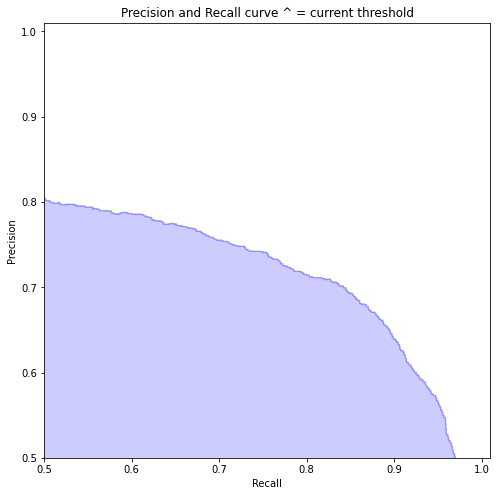

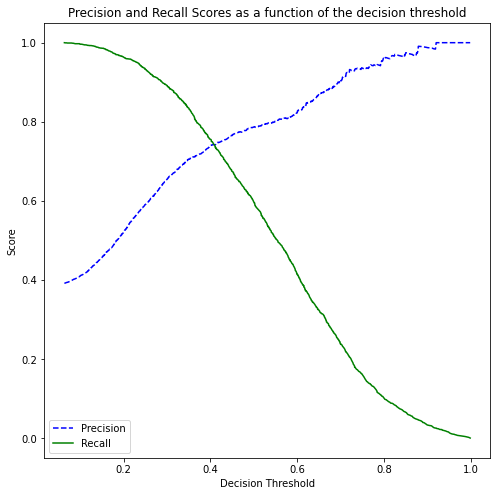

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from matplotlib import pyplot as plt
y_scores = rf.predict_proba(test_features)[:, 1]
p, r, thresholds = precision_recall_curve(test_labels, y_scores)
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(test_labels, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
precision_recall_threshold(p, r, thresholds, 0.95)
plot_precision_recall_vs_threshold(p, r, thresholds)


Plot Decision Trees:

In [ ]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
feature_list = list(newdf.columns)
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')
# Limit depth of tree to 3 levels
rf_small = RandomForestClassifier(n_estimators=10, max_depth = 4, criterion='entropy')
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'mid_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('mid_tree.dot')
graph.write_png('mid_tree.png');

**Test On Spike Protein:**


---







Test on RF with chemical features only: 

1.  Test whole spike protein 
2.  Test on subsequences of the spike protein 



---



In [ ]:
from Bio.SeqUtils.IsoelectricPoint import IsoelectricPoint as IP
from Bio.SeqUtils.ProtParam import ProteinAnalysis
blood_ph = 7.40
def encode_proteins(seq, label):
  DesObject = PyPro.GetProDes(seq)
  ctd = DesObject.GetCTD()
  aad = DesObject.GetAAComp()
  aad.update(ctd)
  aad['label'] = label
  return aad
block = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
all_comb = list(product(block, repeat=2))

def dict_pairs(pairs):
  index_pairs = {}
  for i, pair in enumerate(pairs):
    index_pairs[pair] = i
  return index_pairs
pair_d = dict_pairs(all_comb)
def pairs(lst, k=2):
    return list(zip(*[lst[i:] for i in range(k)]))

def createMatrix(seq, dict_p):
  protein = ProteinAnalysis(seq)
  charge = protein.charge_at_pH(7.4)
  gravy_score = protein.gravy() 
  instability_index = protein.instability_index()
  mat = np.zeros((403))
  two_seq = pairs(seq, 2)
  n = len(two_seq)
  for i in two_seq:
    ind = dict_p[i]
    mat[ind] = mat[ind] + 1
  mat=mat/n
  mat[400] = charge
  mat[401] = gravy_score
  mat[402] = instability_index
  return mat
def split_sequence(sequence, subsequence_length):
  peptide_list = []
  num = len(sequence.strip()) - subsequence_length + 1
  for i in range(num):
    peptide = sequence[i:i + subsequence_length]
    peptide_list.append(peptide)
  return peptide_list
spikeseq = "MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT"
peptide_epitopes = dict()
max_conf = 0
max_epitope =""
num_epitopes = 0
num_non = 0
for i in range(6, 26): # do from 5 to 26
  #spike_peptides = [spikeseq[i:i + 16] for i in range(0, 1265, 16)]
  spike_peptides = split_sequence(spikeseq, i)
  #spike_peptides.append(spikeseq)
  for peptide in spike_peptides:
    peptide_vals = createMatrix(peptide, pair_d)
    pred = rf.predict(np.array(peptide_vals).reshape(1,-1))
    prob  = rf.predict_proba(np.array(peptide_vals).reshape(1,-1))
    if pred[0] == 1:
      conf = prob[0][int(pred[0])]
      if conf > 0.8:
        print(peptide)
        print(conf)
        peptide_epitopes[peptide] = conf
        max_epitope = peptide
        max_conf = conf
        num_epitopes +=1
    else:
      num_non +=1
print(num_epitopes)
print(num_non)
print(max_conf)
print(max_epitope)
print(peptide_epitopes)

# ALTGIAVEQDKNTQEVFAQVKQI
# 1 probability 



QFCNDP
0.80375
AWNSNN
0.82875
GYQPYR
0.805
GYQPYRV
0.85
VRFPNITNLCPFGEVFN
0.80875
PFAMQMAYRFNGIGVTQ
0.885
FAMQMAYRFNGIGVTQN
0.805
AMQMAYRFNGIGVTQNV
0.80875
QMAYRFNGIGVTQNVLY
0.8175
MAYRFNGIGVTQNVLYE
0.885
AYRFNGIGVTQNVLYEN
0.83375
KLQDVVNQNAQALNTLV
0.80125
LQDVVNQNAQALNTLVK
0.833125
QDVVNQNAQALNTLVKQ
0.81375
DVVNQNAQALNTLVKQL
0.88125
VVNQNAQALNTLVKQLS
0.83625
VNQNAQALNTLVKQLSS
0.81875
AISSVLNDILSRLDKVE
0.87
ISSVLNDILSRLDKVEA
0.83375
SSVLNDILSRLDKVEAE
0.8075
SVLNDILSRLDKVEAEV
0.80375
VLNDILSRLDKVEAEVQ
0.81
DILSRLDKVEAEVQIDR
0.80875
ILSRLDKVEAEVQIDRL
0.83875
EAEVQIDRLITGRLQSL
0.83625
RLITGRLQSLQTYVTQQ
0.84625
QLIRAAEIRASANLAAT
0.87
LIRAAEIRASANLAATK
0.80875
EELDKYFKNHTSPDVDL
0.81
YFKNHTSPDVDLGDISG
0.80125
KNHTSPDVDLGDISGIN
0.86875
VYYHKNNKSWMESEFRVY
0.80375
PFAMQMAYRFNGIGVTQN
0.8225
QMAYRFNGIGVTQNVLYE
0.82375
MAYRFNGIGVTQNVLYEN
0.8325
AYRFNGIGVTQNVLYENQ
0.81125
LGKLQDVVNQNAQALNTL
0.81
GKLQDVVNQNAQALNTLV
0.80375
LQDVVNQNAQALNTLVKQ
0.826875
QDVVNQNAQALNTLVKQL
0.8475
DVVNQNAQALNTLVKQLS
0.85

Epitope Locations:

In [ ]:
s1 = "QFCNDP"
s2 = "AWNSNN"
s3 = "GYQPYRV"
s4 = "PFAMQMAYRFNGIGVTQ"
spikeseq = "MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRASANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPAICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDPLQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDLQELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDDSEPVLKGVKLHYT"
s1_loc = spikeseq.find(s1)
print("S1 IN "+ str(s1_loc)+ ": " + str(s1_loc+len(s1)) )
s2_loc = spikeseq.find(s2)
print("S2 IN "+ str(s2_loc)+ ":" + str(s2_loc+len(s2)) )
s3_loc = spikeseq.find(s3)
print("S3 IN "+ str(s3_loc) +":" + str(s3_loc+len(s3)) )
s4_loc = spikeseq.find(s4)
print("S4 IN "+ str(s4_loc) +":" + str(s4_loc+len(s4)) )
block = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
all_comb = list(product(block, repeat=2))

def dict_pairs(pairs):
  index_pairs = {}
  for i, pair in enumerate(pairs):
    index_pairs[pair] = i
  return index_pairs
pair_d = dict_pairs(all_comb)
def pairs(lst, k=2):
    return list(zip(*[lst[i:] for i in range(k)]))
def createMatrix(seq, dict_p):
  protein = ProteinAnalysis(seq)
  charge = protein.charge_at_pH(7.4)
  print("Charge " + str(charge))
  gravy_score = protein.gravy() 
  print("Gravy " + str(gravy_score))
  instability_index = protein.instability_index()
  print("Instability Index " + str(instability_index))
print("QFCNDP")
createMatrix(s1, pair_d)
print(s2)
createMatrix(s2, pair_d)
print(s3)
createMatrix(s3, pair_d)
print(s4)
createMatrix(s4, pair_d)


S1 IN 133: 139
S2 IN 433:439
S3 IN 502:509
S4 IN 895:912
QFCNDP
Charge -1.4666040158283817
Gravy -1.1333333333333335
Instability Index -4.233333333333333
AWNSNN
Charge -0.39219770206852334
Gravy -1.7333333333333334
Instability Index 28.900000000000002
GYQPYRV
Charge 0.5524165639990046
Gravy -1.2000000000000004
Instability Index -0.1999999999999983
PFAMQMAYRFNGIGVTQ
Charge 0.8987973520256656
Gravy 0.13529411764705887
Instability Index -9.647058823529411


Plot Importance Feature Plot:

---



Feature ranking:
1. feature gravy (0.031224)
2. feature charge (0.027533)
3. feature stability (0.026983)
4. feature ('A', 'K') (0.007057)


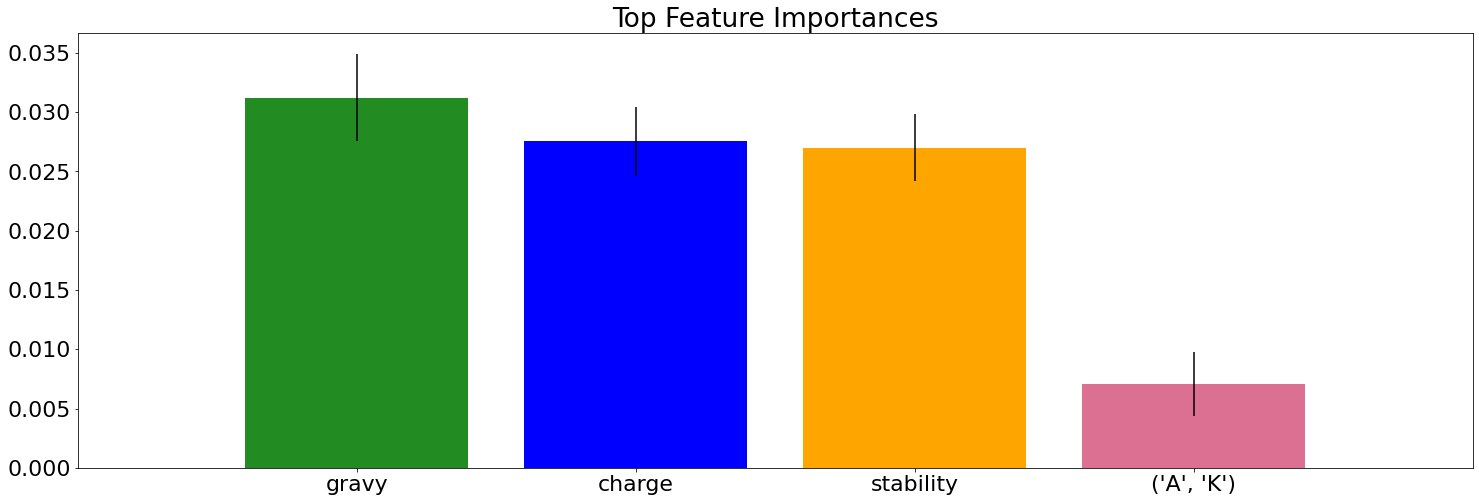

In [ ]:
import matplotlib.pyplot as plt
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 25
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams.update({'font.size': 22})
feature_list = list(newdf.columns)
#print(feature_list)
feature_dict = {}
for i, val in enumerate(feature_list):
  feature_dict[i] = val
#print(feature_dict)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
feature_imp = pd.Series(rf.feature_importances_,index=feature_list).sort_values(ascending=False)
X = train_features[:][400:]
X = X[:][400:]
top = importances[indices]
top = top[:4]
# Print the feature ranking
print("Feature ranking:")
name_indices = []
for f in range(0,4):
    print("%d. feature %s (%f)" % (f + 1, feature_dict[indices[f]], importances[indices[f]]))
    
for i in indices:
  name_indices.append(feature_dict[i])
name_indices = np.array(name_indices)
# Plot the impurity-based feature importances of the forest
plt.figure()
colors = ['y','r','b']
plt.title("Top Feature Importances")
plt.bar(range(4), top,
        color=['forestgreen','b','orange','palevioletred'], yerr=std[indices][:4], align="center")
plt.xticks(range(4), name_indices)
plt.xlim([-1, 4])
plt.savefig('importance_plot.png', dpi=360, facecolor='w', edgecolor='w')
plt.show()

